In [2]:
import os
import numpy as np
from skimage import io, color
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [3]:
# Function to load images from directory
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img / 255)
    return images

In [4]:
# Load images from folders A and B
folder_A = 'trainval/A'
folder_B = 'trainval/B'
folder_label = 'trainval/label'




In [5]:
images_A = load_images_from_folder(folder_A)


In [6]:
print(images_A[40].shape)

(256, 256, 3)


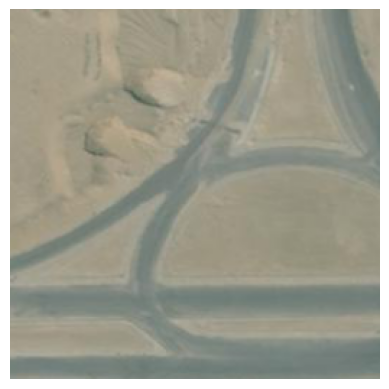

In [7]:
plt.imshow(images_A[40])
plt.axis('off')  
plt.show()

In [8]:
images_B = load_images_from_folder(folder_B)


In [9]:
labels = load_images_from_folder(folder_label)

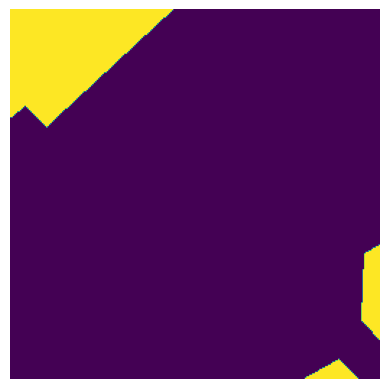

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [10]:
plt.imshow(labels[870])
plt.axis('off')  
plt.show()

print(labels[870])

In [25]:
def calculate_jaccard_index(pred_mask, true_mask):
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    jaccard_index = intersection / union
    return jaccard_index

In [26]:
def image_difference(image_A, image_B, threshold):
    diff = np.abs(image_A - image_B)
    diff_thresholded = diff > threshold
    return diff_thresholded

In [28]:
from skimage import io, color

threshold = 0.1
jaccard_arr = []
# Perform image differencing
for i in range(len(images_A)):
    change_mask = image_difference(color.rgb2gray(images_A[i]), color.rgb2gray(images_B[i]), threshold)
    jaccard_index = calculate_jaccard_index(change_mask, labels[i])
    jaccard_arr.append(jaccard_index)
    print("Jaccard Index:", jaccard_index)

Jaccard Index: 0.005780561010857079
Jaccard Index: 0.03944149838413055
Jaccard Index: 0.05100937274693583
Jaccard Index: 0.02864882613692333
Jaccard Index: 0.0
Jaccard Index: 0.0
Jaccard Index: 0.0
Jaccard Index: 0.0
Jaccard Index: 0.0
Jaccard Index: 0.027962831582772404
Jaccard Index: 0.11242362525458248
Jaccard Index: 0.0
Jaccard Index: 0.019533596694034334
Jaccard Index: 0.02249056053116393
Jaccard Index: 0.0
Jaccard Index: 0.057606021131857
Jaccard Index: 0.006590431406077447
Jaccard Index: 0.0
Jaccard Index: 0.030748309598458808
Jaccard Index: 0.060701956271576527
Jaccard Index: 0.09393548387096774
Jaccard Index: 0.07886122594040515
Jaccard Index: 0.05274173294265383
Jaccard Index: 0.01996159288457651
Jaccard Index: 0.004515203536909438
Jaccard Index: 0.018369837497591367
Jaccard Index: 0.0
Jaccard Index: 0.07869236113650492
Jaccard Index: 0.011887640858531612
Jaccard Index: 0.0
Jaccard Index: 0.03348263054402447
Jaccard Index: 0.020849781673460837
Jaccard Index: 0.0
Jaccard Index

In [29]:
jaccard_arr = np.array(jaccard_arr)
jaccard_index = np.mean(jaccard_arr)
print("Jaccard Index:", jaccard_index)

Jaccard Index: 0.0632290815218716
